<center><h1>Kiva Dataset / Predicting if a loan form Kiva gets funded</h1></center>

<h2><center>Project and Domain Description</center></h2>
<br>
Kiva is a San Francisco based NGO that provides crowd financing for microloans to low income farmers, entrepreneurs and individuals in primarily developing countries. The size of the loans is typically a couple of hundred dollars and they are used to finance a viariaty of activities such as buying livestock, means of production, goods, education etc.<br>
Kiva loans are, compared to loans in developed countries, very small but hthe impact that they have on the living conditions of the borrowers can be significant. Predicting if a loan gets funded is threrefore critical. If we could identify loans that will not get funded we could give the borrower the chance to revise the loan application and resubmit succesfully the application.<br>
<br>
The analysis and prediction is based on the Kiva dataset that can be found under the Kaggle Competition "Data Science for Good: Kiva Crowdfunding". The dataset can be downloaded as a csv file under the following link: https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding/downloads/kiva_loans.csv <br>
It consists of 670.000 rows, one for each loan and 20 columns that will give us the features. The main goal of this project is to predict discrete class labels so we are dealing with Classification.
Throughout the project I will work with three distinct classes, which are: funded loans,partially funded loans and non funded loans. As we will see later the biggest class is composed of fully funded loans. They make more than 92 % of all loan aplications. Our smallest class makes aproximately 0.5 % of all loan apllications.<br>
The chosen algortihms will have to deal with these imbalances. In other words the algorithms will have to able to finde the needle (non funded loans) in the haystack

The problem will be approached from two directions. The first approach will be using standard Sklearn algorithms and the second approach will be using a Keras Neural Network. 

As for the class imbalance I will use two techniques to try to improve the results if the chosen algorithms fails. 
The two techniques will be downsampling the biggest class an the second will consist in augmenting the two smaller classes using the imblearn SMOTE package.







<h2><center>Project Overview</center></h2>
The project is divided into three parts plus an annex that will deal with the question of imbalance. The reason for the separate annex is that augmenting the classes will leave me with a dataset of approximately 1.8 million records and due to the use of a standard 1.7 GHz processor the computing time is pretty large.
<h3>1) Overview and Description of the the three classes</h3>

<li>Preprocessing / Identify nans,outliers</li>
<li>Description and Visualisation of all loans</li>
<li>Preprocessing</li>
<li>Establish a Benchmark</li>
    
<h3>2) Implement 4 Sklearn Algorithms</h3>
<li>Create a pipeline of four Sklearn Algorithms</li>
<li>Select the best performer and fine tune parameters</li>

<h3>3.1) Implement a Keras NN</h3>
<li>Preprocessing of data for Keras</li>
<li>Find the best parameters using Gridsearch</li>
<li>Select the best model and fine tune parameters</li>
<li>Compare the two approaches</li>

<h3>3.2) Dealing with imbalance</h3>
<li>Data reduction and Augmentation</li>




<h2><center>Filestructure</center></h2>

Three separate notebooks covering the three parts(Kiva First Part.ipynb,Keras.ipynb, Resampling.ipynb) plus two folders. The first one for the datafiles and the second one for the weights.

<h2><center>1) Overview and Description of the data and the three classes</h2></center>

<h3>Misclassifications of the target and their consequences</h3>

In the perfect world I would create algorithm were my all my predictions would match the real outcomes. In the real world this will not happen and there will be miscalssifications i.e prediction of an outcome does not match the real outcome. Some of these missclassifications will have a higher negative impact on the borrower. This said we also could end up with positive efects of misclassifications. In order to see what can happen when the algorithm missclassifies I have made a overview of the cases:


| Prediction | Real Outcome   | Consequence   |
|------|------|------|
|   Funded | Non Funded |The borrower will think everything is OK and will not revise his application. The borrowers project will not receive funding and die.|
|   Funded | Partially funded |The borrower will think that his project will be fully funded and will not revise his application. The borrower will receive less funding.|
|   Partially funded  | Non funded |The borrower might improve the application. If he doesn't he will not get funding for his project.|
|   Partially funded | Funded |The borrower might improve the application. But even if he doesn't he will receive the full amount.
|   Non funded | Funded |The borrower will feel that he has to improve his application. But, even if the borrower does nothing he will receive the funds
|   Non funded| Partially funded |The borrower will feel that he has to improve his application.Even if he doesn't there still will be some funding|


As we can see there are two combinations of prediction/outcome that would be detrimental for the borrower. If we predict that a loan will be funded and the real outcome of the loan application is not fundet our borrower might lose a chance to escape poverty. A similar thing happens with the real outcome partially funded and the prediction funded. We don't want any False positives for these two cases.


In [1]:
import pandas as pd
import numpy as np

#load the kiva loans dataset
kiva_raw = pd.read_csv('data_files/kiva_loans.csv')

.describe and .median will give short glimpse of the kiva loans. They are very small with a median of 450 USD. A hefty outlier of 100.000. Note that funded amount is lower than loan amount which indicates that some loans might get underfunded or not funded at all.

In [2]:
kiva_raw.median()

id                992780.0
funded_amount        450.0
loan_amount          500.0
partner_id           145.0
term_in_months        13.0
lender_count          13.0
dtype: float64

In [3]:
kiva_raw.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,6.712050e+05,671205.000000,671205.000000,657698.000000,671205.000000,671205.000000
mean,9.932486e+05,785.995061,842.397107,178.199616,13.739022,20.590922
std,1.966113e+05,1130.398941,1198.660073,94.247581,8.598919,28.459551
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000
25%,8.230720e+05,250.000000,275.000000,126.000000,8.000000,7.000000
50%,9.927800e+05,450.000000,500.000000,145.000000,13.000000,13.000000
75%,1.163653e+06,900.000000,1000.000000,204.000000,14.000000,24.000000
max,1.340339e+06,100000.000000,100000.000000,536.000000,158.000000,2986.000000


<b>Identifying the three classes</b>
We don't have a column that gives us a label whether a loan belongs to one of the three classes so I'll have to find tha label by using thw two exixting columns funded amount and loan_amount. 

We have a fully funded loan when:  <b>loan_amount - funded_amount = 0</b><br> 
We have a  non funded loan when:  <b>funded_amount = 0 </b><br>
We have a partially funded loan when: <b>loan_amount - funded_amount > 0 </b><br>

In [4]:
kiva_non_funded = kiva_raw[kiva_raw['funded_amount'].astype(int) == 0]
kiva_partially_funded= kiva_raw[(kiva_raw['loan_amount'] - kiva_raw['funded_amount'].astype(int)>0) & (kiva_raw['funded_amount'] !=0)]
kiva_funded = kiva_raw[(kiva_raw['loan_amount'] - kiva_raw['funded_amount'].astype(int)==0)]


print('Non funded in %: ',kiva_non_funded.shape[0]/kiva_funded.shape[0]*100)
print('Partially funded in %: ',kiva_partially_funded.shape[0]/kiva_funded.shape[0]*100)

Non funded in %:  0.5431266305438491
Partially funded in %:  7.215733493879189


<center><h2>1.1 Identify nans and outliers</h2></center>

<b>Outlier Detection and Removal</b><br>
As we can see from pd.describe we have alleready a max value that lies extremly far away from the mean (more than 80 times the std). In order to fid out if there are more examples of extrem high loans let's have a look at the distribution of loans.

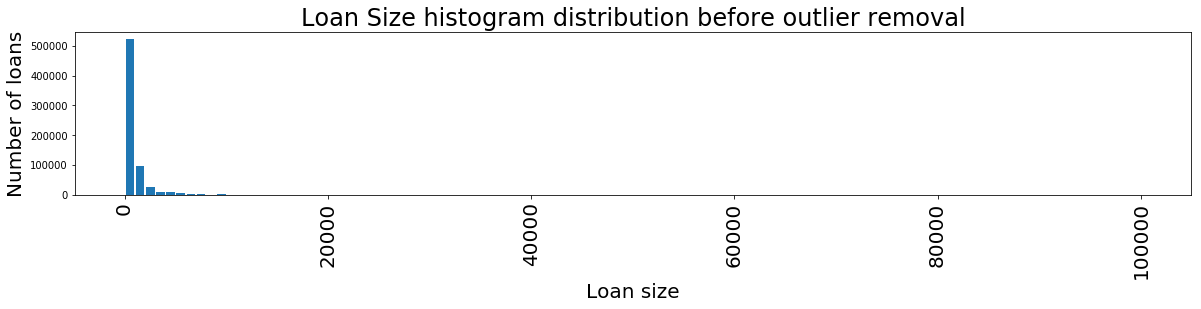

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
loan_amount = kiva_raw.loan_amount

plt.subplots(figsize=(20,3))
plt.hist(loan_amount, bins=100,rwidth=0.85)
plt.ylabel('Number of loans', fontsize=20)
plt.xticks(rotation=90,fontsize=20)

plt.xlabel('Loan size', fontsize=20)
plt.title('Loan Size histogram distribution before outlier removal', fontsize=24)
plt.show()

As we can see most loans have a loan amount between 0 and 10000. So the next step is to find outliers in the general population, analize them and eventually remove them. <br>As we are not dealing with a gausian distribution I cannot use the Z score. I used the method of interquartiale range and I have only focused on the upper bound and disregarded the lower band as the loans are per definition micro/small.

In [6]:

first = kiva_raw.loan_amount.quantile(.25)
third = kiva_raw.loan_amount.quantile(.75)
upper_bound = ((third -first)*1.5)+third
print(upper_bound)

2087.5


The upper bound for our outlier removal would be 2087.5. In order to find out if I have to remove the outliers we have to consider one thing.

The main goal of this project is to predict whether a loan will be funded or not so let's compare the occurrunces of non funded loans in the kiva set with non funded loans and without outliers.

In [7]:
kiva_outliers = kiva_raw.loc[kiva_raw['loan_amount'] > upper_bound]
#get the non funded loans for both groups
non_funded_kiva = kiva_raw.loc[(kiva_raw.funded_amount == 0)]
non_funded_outliers = kiva_outliers.loc[(kiva_outliers.funded_amount == 0)]
#get the number for each group
non_funded_outliers_num = len(non_funded_outliers.index)
non_funded_kiva_num = len(non_funded_kiva.index)
#print(non_funded_outliers_num,non_funded_kiva_num)
#get the percentage for each group
outliers_pct = non_funded_outliers_num/(len(kiva_outliers.index))*100
kiva_pct = non_funded_kiva_num/len(kiva_raw.index)*100

print(non_funded_outliers_num,'loans that represent',outliers_pct,'% off all outliers')
#print (outliers_pct,kiva_pct)
print (non_funded_kiva_num,'loans that represent',kiva_pct, '% off all loans' )

590 loans that represent 1.1570215519777225 % off all outliers
3383 loans that represent 0.5040188913968162 % off all loans


Using the interquartiale range has in this case the risk of information loss as the non funded loans are overrepresented in the outliers.
The fact that non fundet loans are overrepresentet in the outliers could indicate that the some of the amounts of of the feature loan_amount were judged to be to high by the lenders and therefore the outliers could help explain the outcome of a loan application.

We still have some outliers that will distort the visualization of the groups. So I will set a manual threshhold of 10000 in order to produce more compact graphs, but will continue to use the full dataset for the algorithms.


<b>Dealing with nans</b><br>
In this particular case we have to consider the meaning and the consecuence of nan. Submitting a loan application, where some of the information (for example gender or repayment interval) is missing could lead to the result that the loan is not going to be funded. 

Fortunately most of the columns that I am going to use in the project have no nans. There is though one that includes  more than 4000 nans. The column/feature is called use and it is used to give brief description of the purpose of the loan.
As You can see from the box below the non fundet make up 3 percent of the applications where the description in the column use is missing.


In [8]:
nansall = kiva_raw[kiva_raw.use.isna()]

nansall_non_funded = nansall[nansall['funded_amount'].astype(int) == 0]
nansall_partially_funded = nansall[(nansall['loan_amount'] - nansall['funded_amount'].astype(int)>0) & (nansall['funded_amount'] !=0)]

print('Partially funded loans with no descrition of use :',nansall_partially_funded.shape[0])
print('Non funded loans with no descrition of use :',nansall_non_funded.shape[0])
print('non funded loans as a percentage of all loans  with no descrition of use:',nansall_non_funded.shape[0]/nansall.shape[0]*100)
print('Partially funded loans as a percentage of all loans with no descrition of use::',nansall_partially_funded.shape[0]/nansall.shape[0]*100)

Partially funded loans with no descrition of use : 557
Non funded loans with no descrition of use : 131
non funded loans as a percentage of all loans  with no descrition of use: 3.0954631379962194
Partially funded loans as a percentage of all loans with no descrition of use:: 13.161625708884689


<b>Setting an outlier threshhold for visualization purposes</b>

In [9]:
# All loans Threshhold USD 100000
kiva_visual = kiva_raw.loc[kiva_raw['loan_amount'] <= 10000]
kiva_funded_visual = kiva_funded.loc[kiva_funded['loan_amount'] <= 10000]
kiva_non_funded_visual = kiva_non_funded.loc[kiva_non_funded['loan_amount'] <= 10000]
kiva_partially_funded_visual = kiva_partially_funded.loc[kiva_partially_funded['loan_amount'] <= 10000]

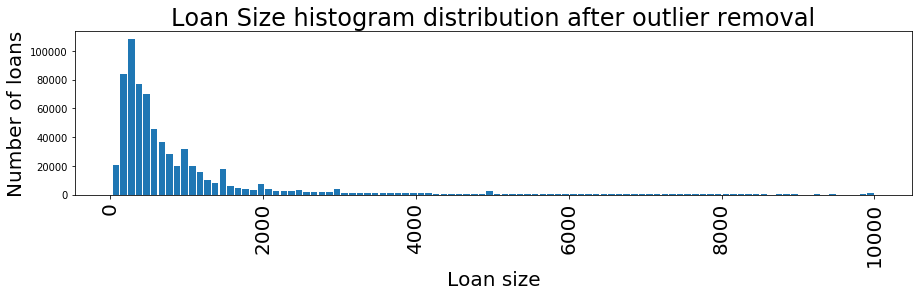

In [10]:
loan_amount = kiva_visual.loan_amount


plt.subplots(figsize=(15,3))
plt.hist(loan_amount, bins=100,rwidth=0.85)

plt.ylabel('Number of loans', fontsize=20)
plt.xticks(rotation=90,fontsize=20)

plt.xlabel('Loan size', fontsize=20)
plt.title('Loan Size histogram distribution after outlier removal', fontsize=24)
plt.show()

<h2><center>1.2 Comparing non funded and partially funded loans with funded loans visualy</center></h2>

In order to to see if we can see patterns in the data I am going to to compare visuly both groups. I am going to focus on four metrics:<br>
<ul>
<li>Amount of the loan
<li>Repayment interval in months
<li>Gender
<li>The biggest 5 sectors

<ul>

<h3><center>Amount of the loan</center></h3>


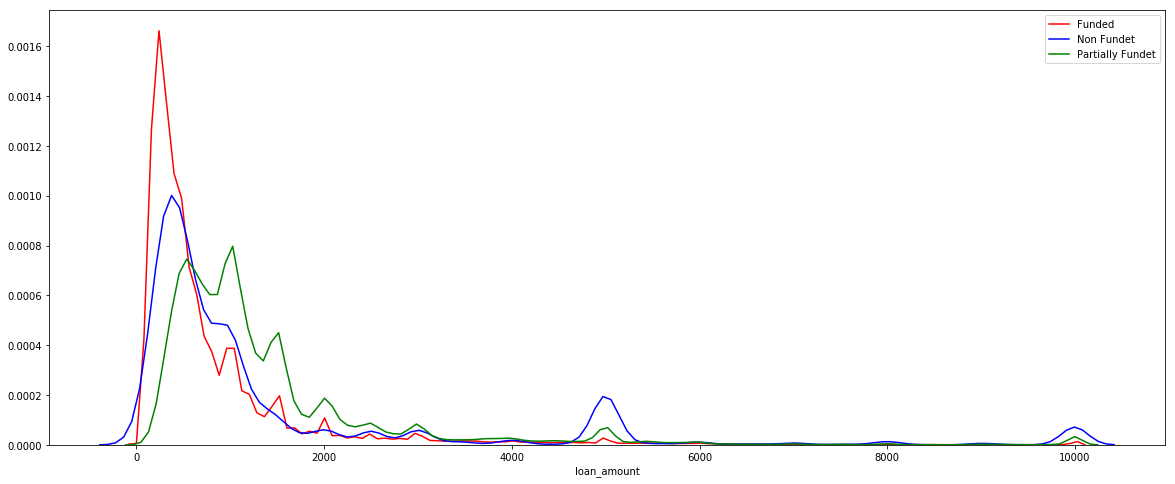

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats




amount = kiva_funded_visual.loan_amount
amount_non_fundet = kiva_non_funded_visual.loan_amount
amount_partially_fundet= kiva_partially_funded_visual.loan_amount




plt.figure(figsize=(20,8))
ax=sns.distplot(amount,hist=False,color='r',label='Funded')
ax=sns.distplot(amount_non_fundet,hist=False, color = 'b',label='Non Fundet')
ax=sns.distplot(amount_partially_fundet,hist=False, color = 'g',label='Partially Fundet')

Looking at the distributins of the three types it is striking that they all show similar patterns. All three are heavily skewed towalds the left. Especially funded and non funded loans show more similarity than funded and partially funded.

<h3><center>Terms in months</center></h3>

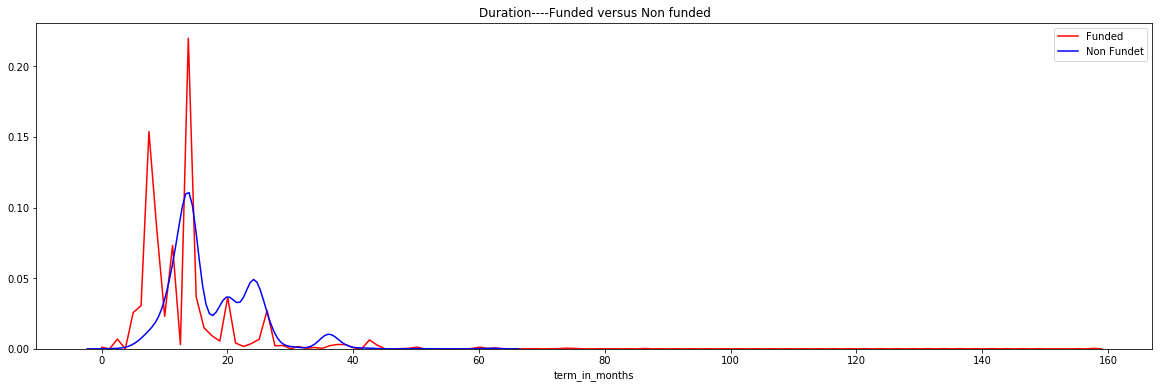

In [12]:
amount = kiva_funded_visual.term_in_months
amount_non_fundet = kiva_non_funded_visual.term_in_months
amount_partially_fundet= kiva_partially_funded_visual.term_in_months




plt.figure(figsize=(20,6))
plt.title('Duration----Funded versus Non funded')
ax=sns.distplot(amount,hist=False,color='r',label='Funded')
ax=sns.distplot(amount_non_fundet,hist=False, color = 'b',label='Non Fundet')
#ax=sns.distplot(amount_partially_fundet,hist=False, color = 'g',label='Partially Fundet')




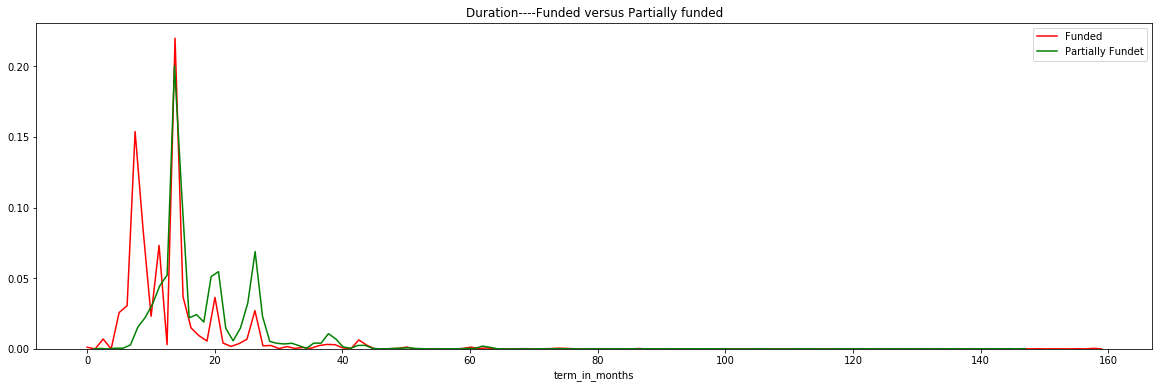

In [13]:
plt.figure(figsize=(20,6))

plt.title('Duration----Funded versus Partially funded')
ax=sns.distplot(amount,hist=False,color='r',label='Funded')
ax=sns.distplot(amount_partially_fundet,hist=False, color = 'g',label='Partially Fundet')


The overall picture for the duration/terms in month does not reveal clear signals on the outcome of a loan applicatin. There are small differences in the distributions such as partially funded loans could be slightly longer.

<h2><center>Loans buy gender</center></h2>

In [14]:
kiva_raw.borrower_genders.value_counts()

female                                                                                                                                                                                                                                                                                                              426502
male                                                                                                                                                                                                                                                                                                                134710
female, female                                                                                                                                                                                                                                                                                                       12164
female, female, female                                 

When we look closer at the value counts of the feature we can distinguish the observations. Most loan application are made by one women, followed by loan application made by one man. We can also see two extra "groups" one is made of loan applications where the gender label is missing. The others cluster of loan application is made uf groups(more than one borrower). They can be mixed (men and women) or single sex.
In order to separate the two genders I will group the applications after the following criteria. A group comprised of only women will be considered Female and the same goes for groups made up of only men.
<br>
The following code implements this idea. I use the split method to split strings around given separator, the "," and then I count the occurrences of women and man for each loan application.


In [15]:
def value_in_borrower_gender(x):
    
    if type(x) is float and np.isnan(x):
        #assign label No Values
        return "No values"
    genders = x.split(",")
    male_count = sum(g.strip() == 'male' for g in genders)
    female_count = sum(g.strip() == 'female' for g in genders)
    
    if(male_count > 0 and female_count > 0):
        #assign label Mi
        return "Mixed Gender"
    elif(female_count > 0):
        return "Female"
    elif (male_count > 0):
        return "Male"

In [16]:
kiva_raw.borrower_genders = kiva_raw.borrower_genders.apply(value_in_borrower_gender)

In [17]:
kiva_non_funded = kiva_raw[kiva_raw['funded_amount'].astype(int) == 0]
kiva_partially_funded = kiva_raw[(kiva_raw['loan_amount'] - kiva_raw['funded_amount'].astype(int)>0) & (kiva_raw['funded_amount'] !=0)]
kiva_funded = kiva_raw[(kiva_raw['loan_amount'] - kiva_raw['funded_amount'].astype(int)==0)]



<h3>Visualizing the relation between loan status and gender</h3>

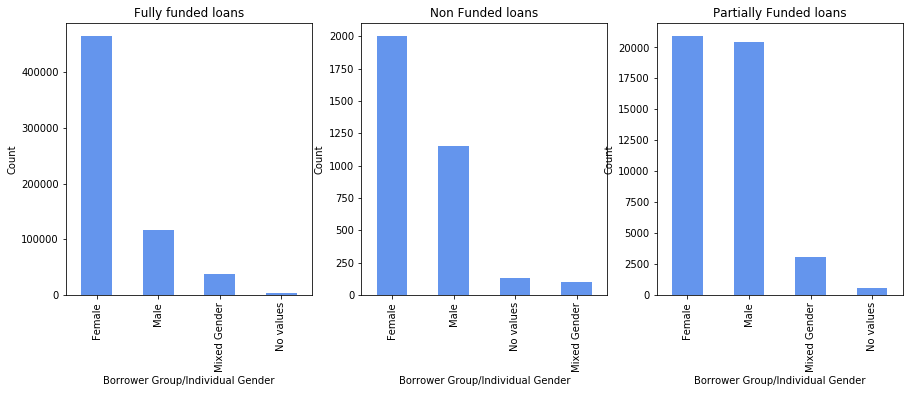

In [18]:
x = ['female','male','mixed','no desc']


fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
kiva_funded.borrower_genders.value_counts().plot.bar(color='cornflowerblue');
plt.xlabel('Borrower Group/Individual Gender')
plt.ylabel('Count')
plt.title("Fully funded loans")

fig.add_subplot(132)
kiva_non_funded.borrower_genders.value_counts().plot.bar(color='cornflowerblue');
plt.xlabel('Borrower Group/Individual Gender')
plt.ylabel('Count')
plt.title("Non Funded loans");


fig.add_subplot(133)
kiva_partially_funded.borrower_genders.value_counts().plot.bar(color='cornflowerblue');
plt.xlabel('Borrower Group/Individual Gender')
plt.ylabel('Count')
plt.title("Partially Funded loans");





<b>Loans by gender  </b> <br>
As for the gender distribution we can see that there are some clear differences.  When we look at the  funded loans we can see that men are a minority. Most funded loans go to women. The picture starts to change when we look at the non funded loans. Women are still outnumbering the men but the proportion of men among non funded loans has risen, In the third group, the partially funded loans, that proportion has risen even more. 
The mixed groups show a mixed behaviour. A slightly higher percentage for the partially funded loans when compared to fully funded and a slightly lower precentage when we compare funded and non funded.

<h3><center>Loans by Sector</center></h3>

<Figure size 1080x576 with 0 Axes>

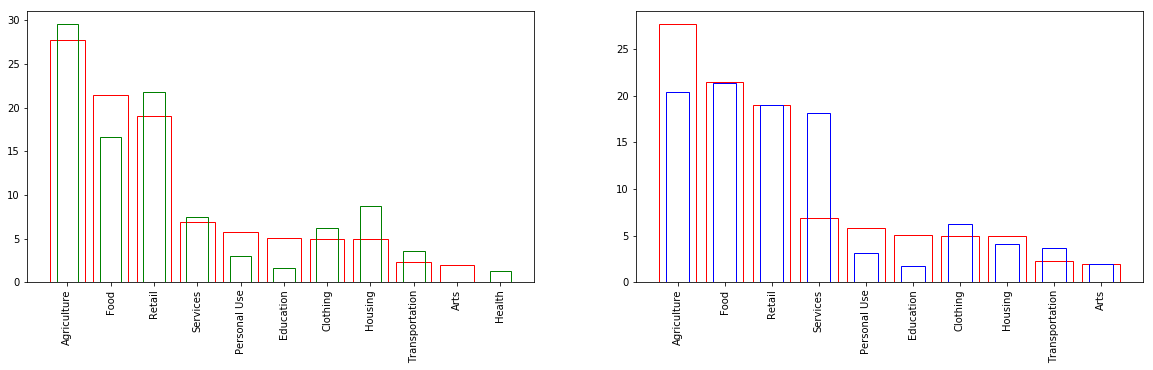

In [19]:
plt.figure(figsize=(15,8))
sect = kiva_funded_visual['sector'].value_counts().head(10)
sect.values.sum()
sect_pct = sect/sect.values.sum()*100


sect_unfunded = kiva_non_funded_visual['sector'].value_counts().head(10)
sect_unfunded.values.sum()
sect_unfunded_pct = sect_unfunded/sect_unfunded.values.sum()*100

sect_partially_funded = kiva_partially_funded_visual['sector'].value_counts().head(10)
sect_partially_funded.values.sum()
sect_partially_funded_pct = sect_partially_funded/sect_partially_funded.values.sum()*100


fig = plt.figure(figsize=(20,5))
fig.add_subplot(121)


plt.bar(sect_pct.index, sect_pct.values,width=0.8,edgecolor='r',align='center', fill=False,label='funded') 
plt.bar(sect_partially_funded.index,sect_partially_funded_pct.values,width=0.5,edgecolor='g',align='center', fill=False, label='partially funded')
leg = ax.legend()
plt.xticks(rotation=90)

fig.add_subplot(122)
plt.bar(sect_pct.index, sect_pct.values,width=0.8,edgecolor='r',align='center', fill=False,label='funded') 
plt.bar(sect_unfunded_pct.index,sect_unfunded_pct.values,width=0.5,edgecolor='b',align='center', fill=False, label='non funded')

leg = ax.legend()
plt.xticks(rotation=90)

plt.show()






Agriculture, Personal use, Housing and Education have slightly higher percentages in the group of non funded loans than in the group with funded loads.
Services has a much higher percentage in the partially funded loans compared with the funded loans.
 

<h2><center>1.3 Results of the description and visualization</center></h2>

<b>Nans and Outiers:</b>The first big takeaway is that both nans and outliers matter in this case. When we think about there is connection behind this. The two small class are not the normal outcome and could therefore be considered as "outliers" of the average result. Both outliers and ans are over represented in the classes non funded and partially funded. The real life logic for the outliers is that when you ask for more money than the project deserves you might get a smaller amount. The real life logic behind the nans is even clearer. When you don't provide enough information the lenders are not going to risk their money.<br>
<b>Gender:</b>If we compare fundet with non fundet loans we can see men have a higer frequency in non funded loans as compared to fundet loans. This does not apply to the comparison funded and partially funded loans, where the distribution is quiet similar<br>
<b>Loan amount, Sector and Terms in months</b> While there are some minor differences in the distributions of these three features in regard to the three classes  it is difficult to see some clear differences.     

<center><h2>1.4 Preprocessing Kiva</h2></center>

Gender: The feature borrower_gender contains unique values for women and men. It contains also mixed group values. In order to have clearer boundaries I will also include single sex loan applications.
Outlier: I will remove the biggest outlier, a 100.000 USD loan that could distort the patterns the algorithms will have to learn.
Attributes: To increase computational speed I will only include the following features/columns:<br>
loan_amount, activity, sector, country,currency,repayment_interval,borrower_genders,lender_count,use
Use: Change the values to No descritiion where there are nans and Description where there was text

In [20]:
#remove the biggest outlier

In [21]:
#drop the columns that are not included
kiva_raw.drop(['id', 'country_code','posted_time','disbursed_time','funded_time','tags','date','region','partner_id' ], axis=1, inplace=True)
#kiva_raw.head()


In [22]:
#create an empty column for the descritpion
kiva_raw.insert(loc = 3, column='description',value = 'Yes')


In [23]:
kiva_raw.head()


,funded_amount,loan_amount,activity,description,sector,use,country,currency,term_in_months,lender_count,borrower_genders,repayment_interval
0,300.0,300.0,Fruits & Vegetables,Yes,Food,"To buy seasonal, fresh fruits to sell.",Pakistan,PKR,12.0,12,Female,irregular
1,575.0,575.0,Rickshaw,Yes,Transportation,to repair and maintain the auto rickshaw used ...,Pakistan,PKR,11.0,14,Female,irregular
2,150.0,150.0,Transportation,Yes,Transportation,To repair their old cycle-van and buy another ...,India,INR,43.0,6,Female,bullet
3,200.0,200.0,Embroidery,Yes,Arts,to purchase an embroidery machine and a variet...,Pakistan,PKR,11.0,8,Female,irregular
4,400.0,400.0,Milk Sales,Yes,Food,to purchase one buffalo.,Pakistan,PKR,14.0,16,Female,monthly


In [24]:
#populate the columnn with the values Description and No Description if there is a text


kiva_raw['use'].fillna('No', inplace=True)
condition_desc = (kiva_raw['use'] =='No')
kiva_raw.loc[condition_desc, 'description'] = 'No'





In [25]:
kiva_raw['description'].value_counts()

Yes    666973
No       4232
Name: description, dtype: int64

In [26]:
kiva_raw.drop(['use'], axis=1, inplace=True)

<center><h2>Preprocessing the Y</h2><center>

<b>Assigning the labels for the three classes</b>The three labels will be Funded, Non funded and partially funded according to the three conditions mentioned at the start of the project. Couriosly there are two loan apllications that didn't match any of the three conditions. There were two loans thart did get a higher funding than asked. Thes two will be removed as they would create an extra and very tiny class. At the same time I will remove the column funded amount as this information is not known when the borrower submits the loan application.


In [27]:
#create a column to hild the labels
#kiva.loan_status.unique()
#create the extra column
kiva_raw.insert(loc = 3, column='loan_status',value = 'placeholder')


In [28]:

#compute and insert partially fondet loans
condition2 = (kiva_raw['loan_amount'] - kiva_raw['funded_amount'].astype(int)>0) & (kiva_raw['funded_amount'] !=0)
kiva_raw.loc[condition2, 'loan_status'] = 'partially funded'
partially_funded = kiva_raw.loc[kiva_raw.loan_status == 'partially funded']
#compute and insert fully fondet loans
condition3 = (kiva_raw['loan_amount'] - kiva_raw['funded_amount'].astype(int)==0)
kiva_raw.loc[condition3, 'loan_status'] = 'Totally funded'
totally_funded = kiva_raw.loc[kiva_raw.loan_status == 'Totally funded']
#compute and insert non fondet loans
condition1 = (kiva_raw['funded_amount'] ==0)
kiva_raw.loc[condition1, 'loan_status'] = 'not funded'
not_funded = kiva_raw.loc[kiva_raw.loan_status == 'not funded']
#find, analyze and remove loans that don'fall into one of the three classes
notvalid = (kiva_raw[(kiva_raw['loan_status']=='placeholder')])
#notvalid.head()

In [29]:
#Remove the two loans that were overfunded
notvalid = (kiva_raw['loan_status']=='placeholder')
kiva_raw = kiva_raw.drop(kiva_raw[notvalid].index)

In [30]:
#REmove the funded amount as this amoun is not known when the borrower submits a loan application
kiva_raw.drop(['funded_amount'], axis=1, inplace=True)

In [31]:
#this extra step is for creating a sample of kiva for later use in GridserchCv for the aufgmented dataset

kiva_ml=kiva_raw
kiva_ml.to_csv('data_files/kiva_ml.csv',index=False)



In [32]:
#Separate the Y from the x / the features 
loan_status = kiva_ml.loan_status
kiva_ml.drop('loan_status', axis=1, inplace=True)

In [33]:

y = loan_status

<b>Encoding the labels</b>

In [34]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
y = labelencoder.fit_transform(y)




In [35]:
kiva_ml = pd.get_dummies(data=kiva_ml, columns=['activity','description', 'sector', 'country','currency','repayment_interval','borrower_genders'])


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(kiva_ml, y, test_size=.2, random_state=42)

<center><h2>1.5 Establishing a Benchmark</h2><center>

I have analized several models to establish a Benchmark for the project. The first was the approach we used in the CNN project were we used a the result of theretical random guess tocompute recall, precision and f1 score. The other approach I analized was a simple linear modell. However, considering the differences in size  of the three classes I wanted aa modell that was better in predicting the small classes, so I decided to use Sklearns logistic regression.


<center><h2>The metrics for the modell</h2><center>

We are dealing with classification and are we intersted in predicting as good as possible, while reducing the number of missclassifications.

In order to understand our metrics we will have to look how the predictions match  the actual values. We have 4 possible results for the combinations prediction and actial value.

Imagine we have two possile states A and B (B beeing not A ie. the opposite value) 

<b>True positives:</b> Our model predicts A and the actual value is A
<b>True negatives:</b> The value we predicts B and the actual value is B

<b>False positves:</b> Our model predicts A but the actual value  is B
<b>False Negatives:</b> Our model predicts B but the actual value is A

Our total actual values of A will becomposed of True Positives and False Negatives


For our modell I will use the followintg metrics:

<center><b>Metrics</b></center>
<b>Recall:</b> True positive / (True positives + False Negatives)<br>
Recall gives us the the ratio of the correct predicited members of a class and the total members of a class.


<b>Precission: :</b> True positive / (True positives + True Negatives)<br>
Gives us the ratio of the between the correct predicted members of a class and the sum of all correct predictions


<b>F1score: :</b> Precision * Recall / Precision+Recall<br>
In order to get the best performing modell we want to balance precsion and reacal. We can combine precision and recall with the harmonic mean from both, called the traditional F-measure or balanced F-score.







In [37]:

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

In [38]:

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_log, target_names=['full funded', 'non funded','partially funded']))

                  precision    recall  f1-score   support

     full funded       0.95      0.99      0.97    124604
      non funded       1.00      0.94      0.97       660
partially funded       0.71      0.25      0.37      8977

     avg / total       0.93      0.94      0.93    134241



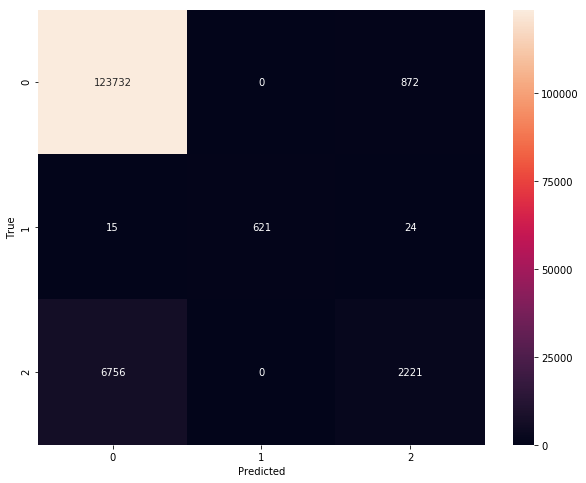

In [48]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


confusion_dnn = confusion_matrix(y_test, y_pred_log)
cmdata = pd.DataFrame(confusion_dnn)
plt.figure(figsize=(10,8))
sns.heatmap(cmdata, annot = True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<b>Performance of the benchmark</b> 

For a basuc model the performance was good for fully funded and non funded loasn. However the modell did not perform weel on the paritally funded loans. We can see non funded and funded loans as two extrems where the partially funded loans are the group in the middle. They probaby share some charactersistics from both groups and a simple algorithm has therefore problems  distinguishing / separating them from the others.

<h1><center>2)Implement 4 Sklearn Algorithms</center></h1>

<h2><center>2.1 Create a pipeline of four Sklearn Algorithms</center></h2>


<b>RandomForestClassifier: </b>A random forest is a meta estimator that uses  a number of individual decision tree classifiers on various parts(subsamples) of the dataset. The RandomForestClassifier uses averaging to improve the predictive accuracy and keeps at the same time overfitting down.
Advantages: Minimizes overfitting, 
Disadvantages: Computationally expensive.
    
<b>MLPClassifier</b> Is the implementation of a feedforward neural network. Multilayer perceptrons, are a combination of multiple neurons connected in the form a network that can solve problems when the data is not linearly separable.<br>
Advantages; can learn linear and non-linear models
Disadvantages: Complex algorithm, computationally expensive

<b>AdaBoostClassifier</b> which is the short form for Adaptive Boosting is, like the RandomForrestClassifier, a meta-estimator. It combines many weak (simple) learners to create a highly accurate prediction. It uses an iterative process where it changes the sample distribution by modifying the weights attached to each of the instances. The weights of wrongly predicted instances are increased and correctly predicted instances are increased.

Advantages: Like RandomForrest it is less prone to overfitting
Disadvantages: AdaBoost can be sensitive to noisy data and outliers. 

<b>GaussianNB</b>Is a classifier that is based on Bayes’ Theorem.  It assumes the independence among predictors and all of the predictors independently contribute to the probability of a the classification outcome.

Advantages: Fast, very simple and straightforward implementation
Disadvantages: The “naive” part. The algorithm makes a very strict assumption that the features are independant.


In [40]:


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  MinMaxScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

classifiers = [GaussianNB(),MLPClassifier(),RandomForestClassifier(),AdaBoostClassifier()]

pipeline = Pipeline([
    ('normalizer', MinMaxScaler()),
    ('clf', LogisticRegression())
])
pipeline.steps



for classifier in classifiers:
    pipeline.set_params(clf = classifier)
    pipeline.fit(X_train,y_train)
    
    y_pred_p = pipeline.predict(X_test)
    
    print(classifier)
    print(metrics.f1_score(y_test, y_pred_p, average='weighted', labels=np.unique(y_pred_p)))
    print(classification_report(y_test,y_pred_p, target_names=['full funded', 'non funded','partially funded']))
    
            

GaussianNB(priors=None)
0.15855449929726328
                  precision    recall  f1-score   support

     full funded       0.99      0.08      0.16    124604
      non funded       0.82      0.98      0.89       660
partially funded       0.07      0.99      0.13      8977

     avg / total       0.93      0.15      0.16    134241

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
0.9585992644220291
                  precision    recall  f1-score   support

     full funded       0.97      0.99      0.98    124604
      non funded       0.74      0.73      0.73       660
partially funded       0.76      0.

<h2><center>Select the best performing classifier  and fine tune parameters</center></h2>

There are two classifiers that perform quite well. Adaboost and Randomforrest
I want the classifier to perform well on the two smallest classes so I chose the Randomforest classifier. It performs slightly worse on for the non funded loans but much better for the partially funded loans when compared to Adaboost.

Regarding the parameters I have chosen to concentrate on three:


<b>n_estimators:</b>This parameter determines the number of individual trees in our forrest. Due to the fact that result of the forest is based on the average of all the trees the the number of trees is not too sensitive to overfitting. So there is a high degree of tuning freedom with this parameter.<br>
<b>max_features:</b>Max_features determines how many features are used for each split. The default is all features. The idea to limit the number of features is to give predominance to the most relevant features.


<b>min_samples_leaf:</b>Gives the minimum number of samples required to be at a leaf node(i.e the leaf at the bottom of the tree). The default value is 1. Smaller leave sizes can could catch noisy data so I will use the default value and 2.





In [41]:
from sklearn.model_selection import RandomizedSearchCV
clasif = RandomForestClassifier()

params = {'max_features': [0.2,0.3,0.4],'min_samples_leaf':[1,2], 'n_estimators':[100,120]}

random_search = RandomizedSearchCV(clasif, param_distributions=params,
                                  n_iter=10, cv=3)

random_result = random_search.fit(X_train, y_train)

In [42]:
print(random_result.best_params_,random_result.best_score_)

{'n_estimators': 120, 'min_samples_leaf': 2, 'max_features': 0.2} 0.9642451421143395


In [43]:
Rf = RandomForestClassifier(max_features=0.3, min_samples_leaf = 2, n_estimators=120)

Rf.fit(X_train, y_train)
y_pred_Rf = Rf.predict(X_test)
print(metrics.f1_score(y_test, y_pred_Rf, average='weighted', labels=np.unique(y_pred_Rf)))
print(classification_report(y_test,y_pred_Rf, target_names=['full funded', 'non funded','partially funded']))

0.9633147250529873
                  precision    recall  f1-score   support

     full funded       0.97      0.99      0.98    124604
      non funded       1.00      1.00      1.00       660
partially funded       0.80      0.64      0.71      8977

     avg / total       0.96      0.97      0.96    134241



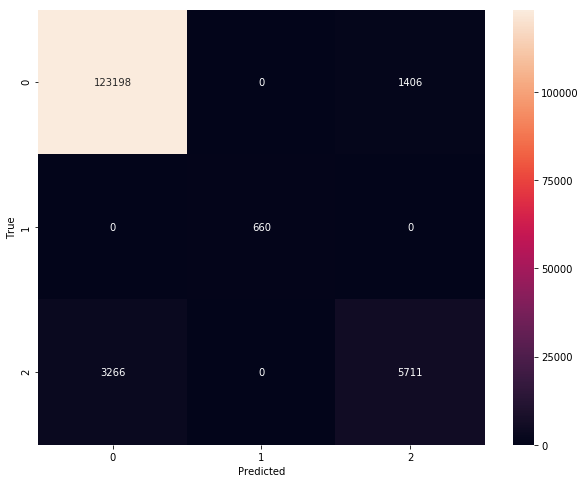

In [49]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

confusion_dnn = confusion_matrix(y_test, y_pred_Rf)
cmdata = pd.DataFrame(confusion_dnn)
plt.figure(figsize=(10,8))
sns.heatmap(cmdata, annot = True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<center><h2>Conclusion of the first part</h2></center>

The best Sklearn classifier shows some really impressive results for the smallest class. Of the non funded loans, that were predicted non funded, all were correct. What's more, as stated in the intro part we had two prediction/reality combinations that could have the biggest negative consequences for the borrower. The two were: predicting a loan to be funded when it really was not funded and predicting a loan to be partially funded while it actually was not funded. There are no instances of these two cases.

There are though, some issues when we look at the classification for the partially and fully funded classes. The biggest number of miscalculations happens between these two.

That could be due to the fact that a partially funded loan shares more common patterns with a funded loan than with non funded loan. A non funded loan has maybe more substantial flaws that makes it easier to be recognized.